# Summary

In [1]:
import os
import sys

In [2]:
import numpy as np
import pandas as pd

In [3]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [4]:
import Reader
import ParamsExtractor2
import DataPreprocessor
import ReduceDim
import ClusterData
import DetectAnomaly

2024-06-26 13:41:54.531949: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 13:41:54.532639: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 13:41:54.551499: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 13:41:54.641162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 13:41:55.477223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Training on normal dataset

In [5]:
log_types = ['cron', 'laurel', 'maillog', 'messages', 'secure', 'user']
dates = ['20240418', '20240420', '20240429']
login_node_numbers = ['01', '02', '03', '10']

# Generate the list of file paths
file_paths = [f'/../../../temp_logs/{date}/login{num}.{logtype}.log' for date in dates for num in login_node_numbers for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]

df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file(file_path)
    df_list.append(df)

In [6]:
existing_file_paths

['/../../../temp_logs/20240418/login01.cron.log',
 '/../../../temp_logs/20240418/login01.laurel.log',
 '/../../../temp_logs/20240418/login01.maillog.log',
 '/../../../temp_logs/20240418/login01.messages.log',
 '/../../../temp_logs/20240418/login01.secure.log',
 '/../../../temp_logs/20240418/login01.user.log',
 '/../../../temp_logs/20240418/login02.cron.log',
 '/../../../temp_logs/20240418/login02.laurel.log',
 '/../../../temp_logs/20240418/login02.maillog.log',
 '/../../../temp_logs/20240418/login02.messages.log',
 '/../../../temp_logs/20240418/login02.secure.log',
 '/../../../temp_logs/20240418/login02.user.log',
 '/../../../temp_logs/20240418/login03.cron.log',
 '/../../../temp_logs/20240418/login03.laurel.log',
 '/../../../temp_logs/20240418/login03.maillog.log',
 '/../../../temp_logs/20240418/login03.messages.log',
 '/../../../temp_logs/20240418/login03.secure.log',
 '/../../../temp_logs/20240418/login03.user.log',
 '/../../../temp_logs/20240418/login10.cron.log',
 '/../../../temp_

In [7]:
len(df_list)

47

In [8]:
df_after = []

for i, df in enumerate(df_list):
    p = ParamsExtractor2.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    df_after.append(new_df)
    df_list[i] = pd.concat([df_list[i], new_df], axis=1)

In [9]:
df_list[0].head()

,host,ident,pid,message,severity,facility,time,severity_numbers,facility_numbers,severity_scores,timedelta,log key,log key spell
0,login01,CROND,37678,(root) CMD ( /cinecalocal/nagios/passive/passi...,info,cron,2024-04-18 00:00:01 +0200,6,9,1.000000,0.0,0,6
1,login01,CROND,37679,(root) CMD (/cinecalocal/scripts/clean_shm_fil...,info,cron,2024-04-18 00:00:01 +0200,6,9,1.000000,0.0,1,-1
2,login01,CROND,37701,(a07cmc01) CMD (/g100_work/CMCC_medfs_0/downlo...,info,cron,2024-04-18 00:00:01 +0200,6,9,1.000000,0.0,2,-1
3,login01,CROND,41587,(root) CMD (run-parts /etc/cron.hourly),info,cron,2024-04-18 00:01:01 +0200,6,9,1.000000,60.0,3,12
4,login01,run-parts,41587,(/etc/cron.hourly) starting 0anacron,notice,cron,2024-04-18 00:01:01 +0200,5,9,2.718282,0.0,4,-1


In [10]:
df_list[0].columns

Index(['host', 'ident', 'pid', 'message', 'severity', 'facility', 'time',
       'severity_numbers', 'facility_numbers', 'severity_scores', 'timedelta',
       'log key', 'log key spell'],
      dtype='object')

In [11]:
for i, df in enumerate(df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    df_list[i] = enc

print(df_list[0].head())

   severity_scores  timedelta  log key  log key spell  col_0  col_1  col_2  \
0         1.000000        0.0        0              6      1      0      1   
1         1.000000        0.0        1             -1      1      0      0   
2         1.000000        0.0        2             -1      1      0      0   
3         1.000000       60.0        3             12      1      0      1   
4         2.718282        0.0        4             -1      0      0      1   

   col_3  col_4  col_5  ...  col_10  col_11  col_12  col_13  col_14  col_15  \
0      0      0      0  ...       0       0       0       0       0       0   
1      0      0      0  ...       0       0       0       0       0       0   
2      0      0      0  ...       0       0       0       0       0       0   
3      0      0      0  ...       0       0       0       0       0       0   
4      0      0      0  ...       0       0       0       0       0       0   

   col_16  col_17  col_18  col_19  
0       0       0   

In [12]:
df_list[0].iloc[0]

severity_scores    1.0
timedelta          0.0
log key            0.0
log key spell      6.0
col_0              1.0
col_1              0.0
col_2              1.0
col_3              0.0
col_4              0.0
col_5              0.0
col_6              0.0
col_7              0.0
col_8              0.0
col_9              1.0
col_10             0.0
col_11             0.0
col_12             0.0
col_13             0.0
col_14             0.0
col_15             0.0
col_16             0.0
col_17             0.0
col_18             0.0
col_19             0.0
Name: 0, dtype: float64

In [13]:
df_list[1]['suid']

0      126858
1           0
2           0
3           0
4           0
        ...  
995         0
996         0
997         0
998        -1
999        -1
Name: suid, Length: 1000, dtype: int64

In [14]:
df_list[0].shape

(557, 24)

In [15]:
df_list[4].head()

,severity_scores,timedelta,port,log key,log key spell,col_0,col_1,col_2,col_3,col_4,...,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,1.0,0.0,-1,96,-1,0,0,0,0,0,...,0,0,3,0,0,0,1,0,0,0
1,1.0,1.0,44266,97,52,1,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,1.0,0.0,-1,96,-1,1,0,0,0,0,...,0,1,2,0,0,0,0,0,0,0
3,1.0,0.0,44266,98,-1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1.0,0.0,44266,99,55,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [16]:
for df in df_list:
    print(df.shape)

(557, 24)
(1000, 24)
(570, 25)
(1000, 24)
(1000, 25)
(37, 25)
(1000, 24)
(1000, 24)
(25, 24)
(1000, 24)
(1000, 25)
(57, 25)
(337, 24)
(1000, 24)
(20, 24)
(1000, 24)
(1000, 25)
(14, 25)
(390, 24)
(1000, 24)
(10, 24)
(1000, 24)
(1000, 25)
(1, 24)
(557, 24)
(1000, 24)
(570, 25)
(1000, 24)
(1000, 25)
(19, 25)
(1000, 24)
(1000, 24)
(10, 24)
(1000, 24)
(1000, 25)
(337, 24)
(1000, 24)
(15, 24)
(1000, 24)
(1000, 25)
(2, 25)
(385, 24)
(1000, 24)
(10, 24)
(1000, 24)
(1000, 25)
(3, 25)


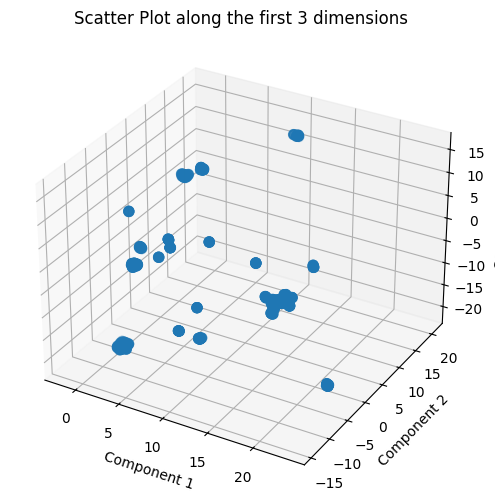

In [17]:
r = ReduceDim.ReduceDim(3, df_list[0], [1,0])
umap_reduced_data = r.umap()

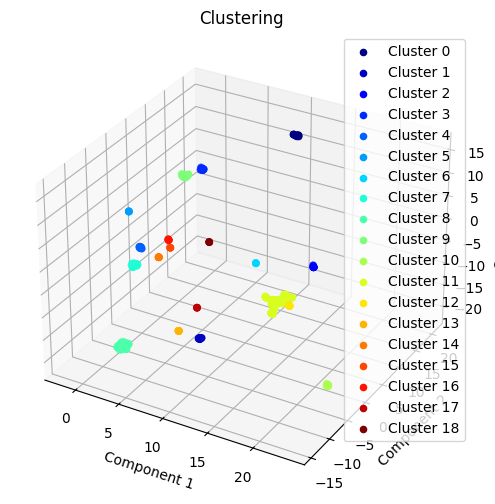

In [18]:
c = ClusterData.ClusterData(umap_reduced_data, [1,0])
dbscan_clustered_data = c.dbscan()

In [19]:
d = DetectAnomaly.DetectAnomaly(umap_reduced_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

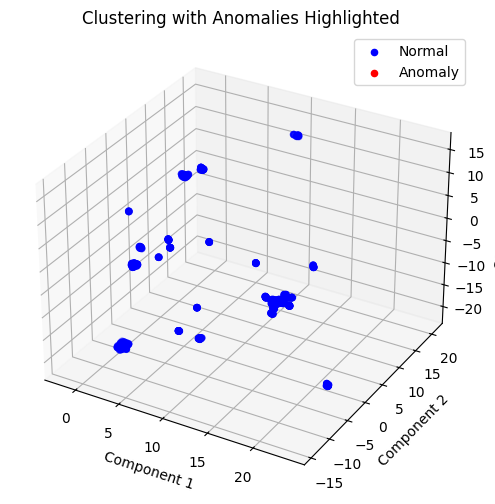

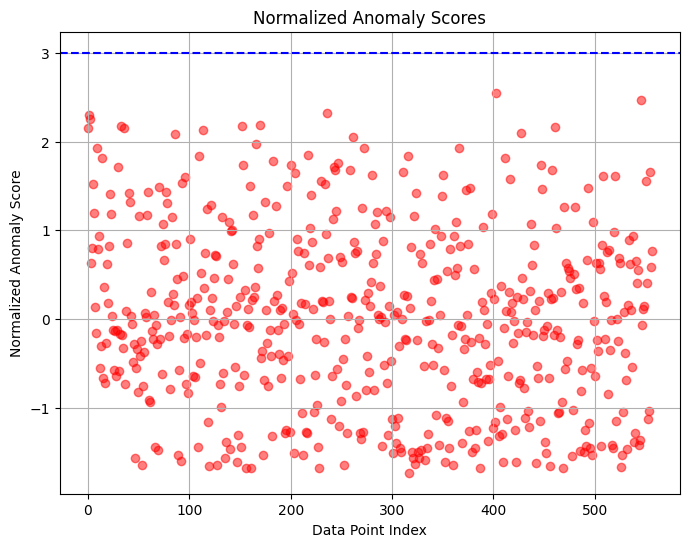

In [20]:
threshold = 0.1 # change of threshold
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

## Testing on anomalous dataset

In [21]:
import os
os.getcwd()

'/home/rocky/repo/Thesis/notebooks'

In [22]:
os.listdir('../data/linpeas_logs_1/')

['cron_logs.log',
 'laurel_logs.log',
 'report.txt',
 'secure_logs.log',
 'user_logs.log',
 '.ipynb_checkpoints']

In [23]:
log_types = ['cron', 'secure', 'user']

# Generate the list of file paths
file_paths = [f'../data/linpeas_logs_1/{logtype}_logs.log' for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]

an_df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file_2(file_path)
    an_df_list.append(df)

In [24]:
an_df_list[1].head()

,host,ident,pid,message,severity,facility,time
0,localhost,sudo[3680]:,3680,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:39.520333-04:00
1,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:39.526046-04:00
2,localhost,sudo[3680]:,3680,pam_unix(sudo:session): session closed for use...,info,authpriv,2024-06-22T11:55:39.974240-04:00
3,localhost,sudo[3693]:,3693,matteo : TTY=pts/0 ; PWD=/home/matteo ; USER...,notice,authpriv,2024-06-22T11:55:46.643379-04:00
4,localhost,sudo[3693]:,3693,pam_unix(sudo:session): session opened for use...,info,authpriv,2024-06-22T11:55:46.655326-04:00


In [25]:
an_df_after = []

for i, df in enumerate(an_df_list):
    p = ParamsExtractor2.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    an_df_after.append(new_df)
    an_df_list[i] = pd.concat([an_df_list[i], new_df], axis=1)

In [26]:
an_df_list[0].head()

,host,ident,pid,message,severity,facility,time,severity_numbers,facility_numbers,severity_scores,timedelta,log key,log key spell
0,localhost,CROND[3846]:,3846,(root) CMD (run-parts /etc/cron.hourly),info,cron,2024-06-22T12:01:01.366007-04:00,6,9,1.000000,0.000000,3,12
1,localhost,run-parts[3849]:,3849,(/etc/cron.hourly) starting 0anacron,notice,cron,2024-06-22T12:01:01.426545-04:00,5,9,2.718282,0.060538,4,-1
2,localhost,run-parts[3861]:,3861,(/etc/cron.hourly) finished 0anacron,notice,cron,2024-06-22T12:01:01.485245-04:00,5,9,2.718282,0.058700,7,-1
3,localhost,CROND[3845]:,3845,(root) CMDEND (run-parts /etc/cron.hourly),info,cron,2024-06-22T12:01:01.487222-04:00,6,9,1.000000,0.001977,3,12
4,localhost,crond[935]:,935,(CRON) STARTUP (1.5.7),info,cron,2024-06-23T05:29:44.248136-04:00,6,9,1.000000,62922.760914,407,-1


In [27]:
for i, df in enumerate(an_df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    an_df_list[i] = enc

print(an_df_list[0].head())

   severity_scores     timedelta  log key  log key spell  col_0  col_1  col_2  \
0         1.000000      0.000000        3             12      0      0      0   
1         2.718282      0.060538        4             -1      0      0      0   
2         2.718282      0.058700        7             -1      0      0      0   
3         1.000000      0.001977        3             12      0      0      0   
4         1.000000  62922.760914      407             -1      1      0      0   

   col_3  col_4  col_5  ...  col_10  col_11  col_12  col_13  col_14  col_15  \
0      1      0      0  ...       0       0       0       0       0       0   
1      0      1      0  ...       0       0       0       0       0       0   
2      0      0      0  ...       1       0       0       0       0       0   
3      0      1      0  ...       0       0       1       0       0       0   
4      0      0      0  ...       0       0       1       0       0       0   

   col_16  col_17  col_18  col_19  
0 

In [28]:
# we test secure
# we take the first 5 lines
normal_dataset = df_list[4]
anomalous_dataset = an_df_list[1]

In [29]:
an_df_list[1].head()

,severity_scores,timedelta,port,log key,log key spell,col_0,col_1,col_2,col_3,col_4,...,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,2.718282,0.000000,-1,414,-1,1,1,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1,1.000000,0.005713,-1,415,-1,1,1,0,0,0,...,0,0,2,0,0,0,0,0,0,0
2,1.000000,0.448194,-1,100,53,2,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2.718282,6.669139,-1,416,56,0,0,0,0,0,...,0,0,2,0,0,2,0,0,0,0
4,1.000000,0.011947,-1,415,-1,0,0,0,0,0,...,0,0,2,0,0,2,0,0,0,0


In [30]:
df_list[4].head()

,severity_scores,timedelta,port,log key,log key spell,col_0,col_1,col_2,col_3,col_4,...,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,1.0,0.0,-1,96,-1,0,0,0,0,0,...,0,0,3,0,0,0,1,0,0,0
1,1.0,1.0,44266,97,52,1,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,1.0,0.0,-1,96,-1,1,0,0,0,0,...,0,1,2,0,0,0,0,0,0,0
3,1.0,0.0,44266,98,-1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1.0,0.0,44266,99,55,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [31]:
new_df = pd.concat([df_list[4], an_df_list[1]], axis=0, ignore_index=False)

In [32]:
new = df_list[4]

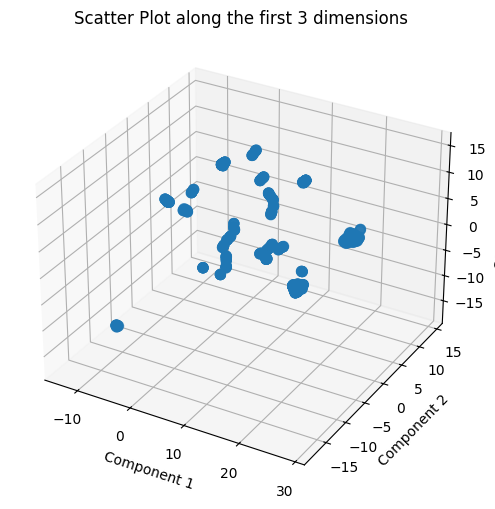

In [33]:
r = ReduceDim.ReduceDim(3, df_list[4], [1,0])
umap_reduced_data = r.umap()

In [35]:
anomalous_data = an_df_list[1].iloc[240:280]
anomalous_points = r.test_umap(anomalous_data)

new_data = np.vstack([umap_reduced_data, anomalous_points])
print(new_data)

[[15.969527   12.258552   -4.874208  ]
 [ 1.7034155   0.69420666 -6.592806  ]
 [17.224499   13.454129   -5.0263543 ]
 ...
 [15.215357    2.1817217  12.72886   ]
 [15.156843    2.4352524  12.517603  ]
 [15.1549225   2.0918114  12.732201  ]]


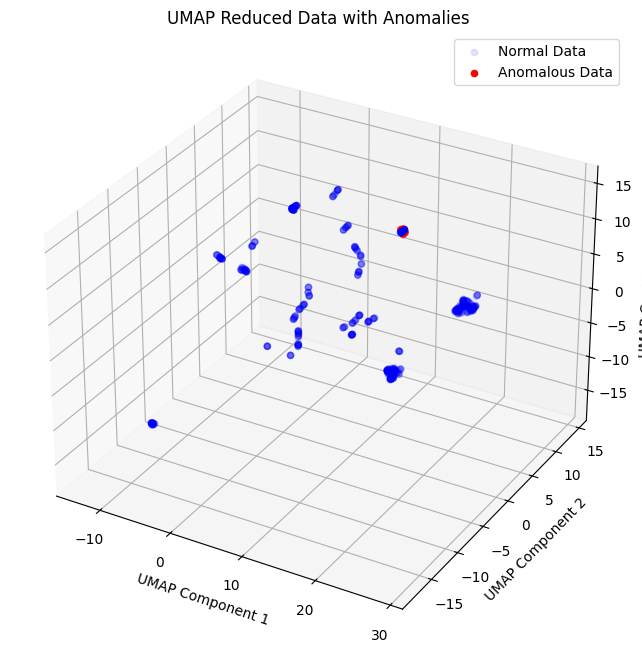

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming umap_reduced_data and anomalous_points have 3 components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal data in blue
ax.scatter(umap_reduced_data[:, 0], umap_reduced_data[:, 1], umap_reduced_data[:, 2], color='blue', alpha=0.1, label='Normal Data')

# Plot anomalous data in red
ax.scatter(anomalous_points[:, 0], anomalous_points[:, 1], anomalous_points[:, 2], color='red', label='Anomalous Data')

ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.set_title('UMAP Reduced Data with Anomalies')
ax.legend()

plt.show()


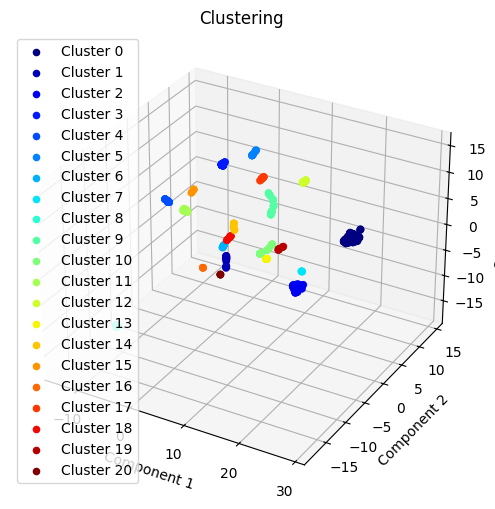

In [37]:
c = ClusterData.ClusterData(umap_reduced_data, [1,0])
dbscan_clustered_data = c.dbscan()

In [38]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,1])
anomaly_scores = d.isolation_forest()

Anomaly indices: [ 84 260 291 310 419 482 927 946 966]
Anomaly data points: [[-13.1282625  -7.473661  -17.206469 ]
 [-13.248837   -7.460433  -17.060305 ]
 [-12.980317   -7.70119   -17.14352  ]
 [-12.898085   -7.341589  -17.176695 ]
 [-12.888477   -7.3305516 -17.177343 ]
 [-13.03366    -7.6806197 -17.187925 ]
 [-13.115304   -7.703431  -16.868542 ]
 [-13.214001   -7.458142  -16.967403 ]
 [-13.232786   -7.4154496 -17.0837   ]]


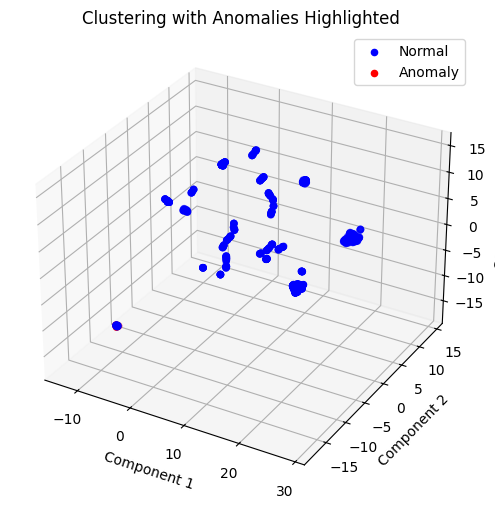

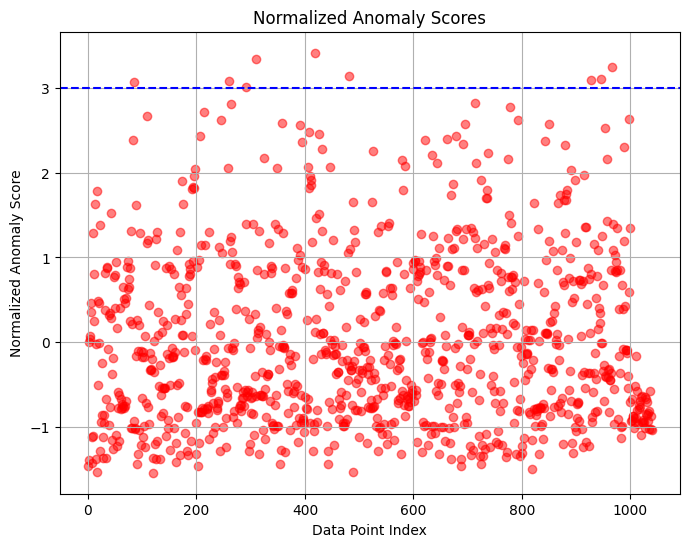

In [39]:
threshold = 0.1 # change of threshold
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

Conclusion of summary 5:
Anomalous behaviours can be clustered properly and are identified as part of a cluster (cluster 12). however they are not detected by traditional algorithms since here the key is that the same command is repeated many times and we are not dealing with the time information. Now let's try deep learning.